<a href="https://colab.research.google.com/github/miebi1/Fall-Armyworm-AI-Classification-Project-/blob/main/Project_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title Install Updated pip
!pip install --upgrade pip

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#@title Installing All Required Libraries for the Fall Armyworm AI Detection Project
!pip install tensorflow keras tf2onnx onnx onnxruntime matplotlib scikit-learn opencv-python albumentations --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.


In [7]:
#@title Library Imports and Environment Configuration
# Core
import os
import numpy as np
import matplotlib.pyplot as plt

# Data and image handling
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Deep learning (Keras / TensorFlow)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Model conversion
import tf2onnx
import onnx
import onnxruntime as ort

# Data augmentation (optional)
import albumentations as A


In [8]:
#@title Verifying Google Drive Mounted Successfully
!ls /content/drive/MyDrive/

'CamScanner 03-21-2025 16.45 (1).gdoc'
'CamScanner 03-21-2025 16.45.gdoc'
'CamScanner 03-21-2025 16.45.pdf'
'Colab Notebooks'
 DO_NOT_DELETE_FOR_Bitget_Wallet_Backup
'Geography SS2 Objective Questions.gdoc'
'Getting started.pdf'
 GROUP_R_PROJECT
'SS1 Geography Objective Questions Answer Sheet.gdoc'
'SS1 Geography Objective Questions.gdoc'


In [9]:
#@title Defining Dataset Paths and Verifying Class Folders
# Path to your dataset
DATA_DIR = '/content/drive/MyDrive/GROUP_R_PROJECT'

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

print("Train classes:", os.listdir(TRAIN_DIR))
print("Test classes:", os.listdir(TEST_DIR))


Train classes: ['healthy', 'larva', 'damage']
Test classes: ['healthy', 'damage', 'larva']


In [10]:
#@title Image Preprocessing and Data Augmentation
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training data generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # we'll create a validation split from the training set
)

# Validation split from the train folder
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2114 images belonging to 3 classes.
Found 527 images belonging to 3 classes.
Found 802 images belonging to 3 classes.


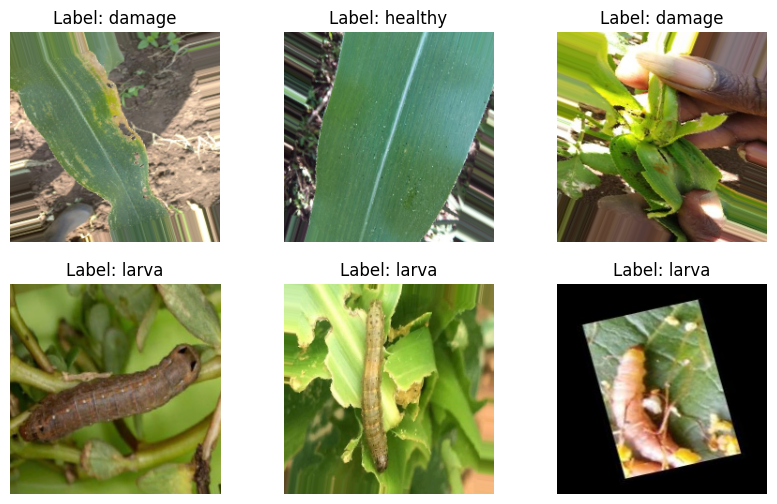

In [11]:
#@title Visualizing Sample Images from the Training Dataset
# import matplotlib.pyplot as plt
# import numpy as np

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {list(train_generator.class_indices.keys())[np.argmax(y_batch[i])]}")
    plt.axis('off')
plt.show()


In [12]:
#@title Building the Deep Learning Model Using MobileNetV2 (Transfer Learning)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Number of output classes (update if yours differ)
num_classes = len(train_generator.class_indices)

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers (so we only train the top layers)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
#@title Model Training with Early Stopping and Checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_faw_model.keras', monitor='val_accuracy', save_best_only=True)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # increase to 15–20 if you have more compute
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 552s 8s/step - accuracy: 0.8721 - loss: 0.3424 - val_accuracy: 0.9715 - val_loss: 0.0621
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9709 - loss: 0.0939 - val_accuracy: 0.9734 - val_loss: 0.0833
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9743 - loss: 0.0914 - val_accuracy: 0.9772 - val_loss: 0.0788
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9839 - loss: 0.0434 - val_accuracy: 0.9810 - val_loss: 0.0894
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9845 - loss: 0.0549 - val_accuracy: 0.9753 - val_loss: 0.1032
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9864 - loss: 0.0580 - val_accuracy: 0.9734 - val_loss: 0.1331
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9846 - loss: 0.0715 - val_accuracy: 0.9810 - val_loss: 0.1125


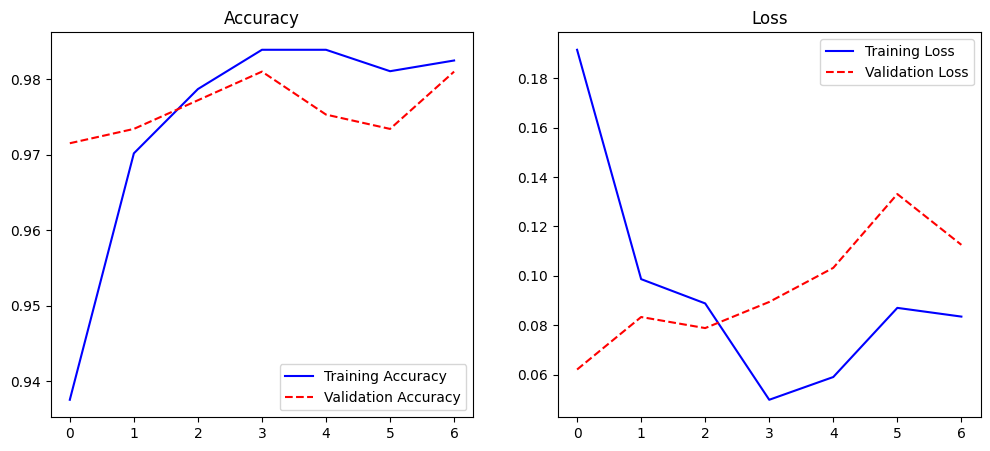

In [14]:
#@title Visualizing Model Training Performance
# import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [15]:
#@title Model Evaluation on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 170s 7s/step - accuracy: 0.9559 - loss: 0.2192
✅ Test Accuracy: 96.38%


26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Classification Report:
              precision    recall  f1-score   support

      damage       0.88      0.96      0.92       171
     healthy       0.98      0.82      0.89       101
       larva       0.99      0.99      0.99       530

    accuracy                           0.96       802
   macro avg       0.95      0.93      0.93       802
weighted avg       0.97      0.96      0.96       802



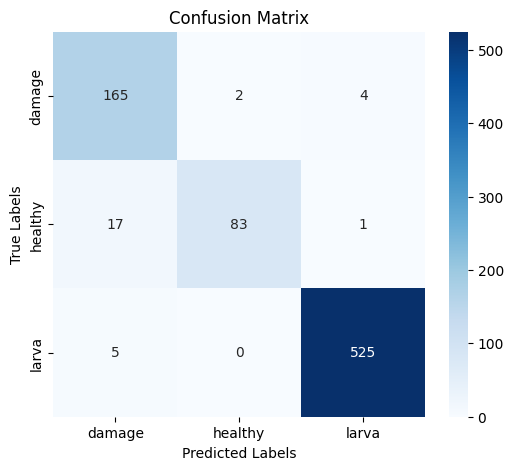

In [16]:
#@title Model Performance Evaluation: Accuracy, Precision, Recall, F1-Score, and Confusion Matrix
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predicted labels
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# Convert predicted probabilities to class labels
y_pred = np.argmax(predictions, axis=1)

# Get true labels from the generator
y_true = test_generator.classes

# Get class names (from generator)
class_labels = list(test_generator.class_indices.keys())

# Classification Report (Precision, Recall, F1-score)
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [17]:
#@title Model Export to ONNX Format
# !pip install tf2onnx onnx onnxruntime --quiet

# import tf2onnx
# import tensorflow as tf

spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
output_path = "faw_model.onnx"

# Convert to ONNX
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=output_path)

print("✅ Model successfully exported to ONNX format!")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7d4ac42732e0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ Model successfully exported to ONNX format!


In [18]:
#@title Loading the Exported ONNX Model for Inference Purpose
# Path to your exported ONNX model
onnx_model_path = "/content/faw_model.onnx"

# Create ONNX runtime session
session = ort.InferenceSession(onnx_model_path)


In [20]:
#@title Building an Interactive Web Interface for Fall Armyworm Detection Using Gradio

!pip install gradio

import gradio as gr
import onnxruntime as ort
import numpy as np
import cv2

session = ort.InferenceSession("/content/faw_model.onnx")
class_names = ['damage', 'healthy', 'larva']  # match your correct order

def predict_image(img):
    img = cv2.resize(img, (224, 224))
    img_norm = img.astype(np.float32) / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    preds = session.run([session.get_outputs()[0].name],
                        {session.get_inputs()[0].name: img_input})[0]
    pred_class = np.argmax(preds, axis=1)[0]
    conf = np.max(preds)
    return {class_names[pred_class]: float(conf)}

gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=3),
    title="Fall Armyworm Classifier"
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0715d936a48bd01c84.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
